<a href="https://colab.research.google.com/github/ykitaguchi77/Colab_Scripts/blob/master/mediapipe_iris.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install mediapipe

import mediapipe as mp
mp_drawing = mp.solutions.drawing_utils
mp_hands = mp.solutions.hands

import cv2

#サポートパッチのインポート
from google.colab.patches import cv2_imshow

     |████████████████████████████████| 32.2MB 95kB/s 


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#**動画用module**

#**Landmarks**

In [3]:
#Face Mesh

#!/usr/bin/env python
# -*- coding: utf-8 -*-
import cv2 as cv
import numpy as np
import mediapipe as mp


class FaceMesh(object):
    def __init__(
        self,
        max_num_faces=1,
        min_detection_confidence=0.7,
        min_tracking_confidence=0.7,
    ):
        mp_face_mesh = mp.solutions.face_mesh
        self._face_mesh = mp_face_mesh.FaceMesh(
            max_num_faces=max_num_faces,
            min_detection_confidence=min_detection_confidence,
            min_tracking_confidence=min_tracking_confidence,
        )

    def __call__(
        self,
        image,
    ):
        # 推論
        image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
        results = self._face_mesh.process(image)

        # X,Y座標を相対座標から絶対座標に変換
        # [X座標, Y座標, Z座標, Visibility, Presence]のリストに変更
        face_mesh_results = []
        if results.multi_face_landmarks is not None:
            for face_landmarks in results.multi_face_landmarks:
                face_mesh_results.append(
                    self._calc_landmarks(image, face_landmarks.landmark))
        return face_mesh_results

    def _calc_landmarks(self, image, landmarks):
        image_width, image_height = image.shape[1], image.shape[0]

        landmark_list = []
        for _, landmark in enumerate(landmarks):
            landmark_x = min(int(landmark.x * image_width), image_width - 1)
            landmark_y = min(int(landmark.y * image_height), image_height - 1)

            landmark_list.append((landmark_x, landmark_y, landmark.z,
                                  landmark.visibility, landmark.presence))
        return landmark_list

    def _calc_bounding_rect(self, landmarks):
        landmark_array = np.empty((0, 2), int)

        for _, landmark in enumerate(landmarks):
            landmark_x = int(landmark[0])
            landmark_y = int(landmark[1])

            landmark_point = [np.array((landmark_x, landmark_y))]
            landmark_array = np.append(landmark_array, landmark_point, axis=0)

        x, y, w, h = cv.boundingRect(landmark_array)

        return [x, y, x + w, y + h]

    def get_eye_landmarks(self, landmarks):
        # 目の輪郭の座標列を取得

        left_eye_landmarks = []
        right_eye_landmarks = []

        if len(landmarks) > 0:
            # 参考：https://github.com/tensorflow/tfjs-models/blob/master/facemesh/mesh_map.jpg
            # 左目
            left_eye_landmarks.append((landmarks[133][0], landmarks[133][1]))
            left_eye_landmarks.append((landmarks[173][0], landmarks[173][1]))
            left_eye_landmarks.append((landmarks[157][0], landmarks[157][1]))
            left_eye_landmarks.append((landmarks[158][0], landmarks[158][1]))
            left_eye_landmarks.append((landmarks[159][0], landmarks[159][1]))
            left_eye_landmarks.append((landmarks[160][0], landmarks[160][1]))
            left_eye_landmarks.append((landmarks[161][0], landmarks[161][1]))
            left_eye_landmarks.append((landmarks[246][0], landmarks[246][1]))
            left_eye_landmarks.append((landmarks[163][0], landmarks[163][1]))
            left_eye_landmarks.append((landmarks[144][0], landmarks[144][1]))
            left_eye_landmarks.append((landmarks[145][0], landmarks[145][1]))
            left_eye_landmarks.append((landmarks[153][0], landmarks[153][1]))
            left_eye_landmarks.append((landmarks[154][0], landmarks[154][1]))
            left_eye_landmarks.append((landmarks[155][0], landmarks[155][1]))

            # 右目
            right_eye_landmarks.append((landmarks[362][0], landmarks[362][1]))
            right_eye_landmarks.append((landmarks[398][0], landmarks[398][1]))
            right_eye_landmarks.append((landmarks[384][0], landmarks[384][1]))
            right_eye_landmarks.append((landmarks[385][0], landmarks[385][1]))
            right_eye_landmarks.append((landmarks[386][0], landmarks[386][1]))
            right_eye_landmarks.append((landmarks[387][0], landmarks[387][1]))
            right_eye_landmarks.append((landmarks[388][0], landmarks[388][1]))
            right_eye_landmarks.append((landmarks[466][0], landmarks[466][1]))
            right_eye_landmarks.append((landmarks[390][0], landmarks[390][1]))
            right_eye_landmarks.append((landmarks[373][0], landmarks[373][1]))
            right_eye_landmarks.append((landmarks[374][0], landmarks[374][1]))
            right_eye_landmarks.append((landmarks[380][0], landmarks[380][1]))
            right_eye_landmarks.append((landmarks[381][0], landmarks[381][1]))
            right_eye_landmarks.append((landmarks[382][0], landmarks[382][1]))

        return left_eye_landmarks, right_eye_landmarks

    def calc_eye_bbox(self, landmarks):
        # 目に隣接するバウンディングボックスを取得

        left_eye_lm, right_eye_lm = self.get_eye_landmarks(landmarks)

        left_eye_bbox = self._calc_bounding_rect(left_eye_lm)
        right_eye_bbox = self._calc_bounding_rect(right_eye_lm)

        return left_eye_bbox, right_eye_bbox

    def calc_around_eye_bbox(self, landmarks, around_ratio=0.5):
        # 目の周囲のバウンディングボックスを取得

        left_eye_bbox, right_eye_bbox = self.calc_eye_bbox(landmarks)

        left_eye_bbox = self._calc_around_eye(left_eye_bbox, around_ratio)
        right_eye_bbox = self._calc_around_eye(right_eye_bbox, around_ratio)

        return left_eye_bbox, right_eye_bbox

    def _calc_around_eye(self, bbox, around_ratio=0.5):
        x1, y1, x2, y2 = bbox
        x = x1
        y = y1
        w = x2 - x1
        h = y2 - y1

        cx = int(x + (w / 2))
        cy = int(y + (h / 2))
        square_length = max(w, h)
        x = int(cx - (square_length / 2))
        y = int(cy - (square_length / 2))
        w = square_length
        h = square_length

        around_ratio = 0.5
        x = int(x - (square_length * around_ratio))
        y = int(y - (square_length * around_ratio))
        w = int(square_length * (1 + (around_ratio * 2)))
        h = int(square_length * (1 + (around_ratio * 2)))

        return [x, y, x + w, y + h]




#iris landmark

#!/usr/bin/env python
# -*- coding: utf-8 -*-
import cv2 as cv
import numpy as np
import tensorflow as tf

class IrisLandmark(object):
    def __init__(
        self,
        model_path='/content/drive/MyDrive/Deep_learning/iris_landmark.tflite',
        num_threads=1,
    ):
        self._interpreter = tf.lite.Interpreter(model_path=model_path,
                                                num_threads=num_threads)
        self._interpreter.allocate_tensors()
        self._input_details = self._interpreter.get_input_details()
        self._output_details = self._interpreter.get_output_details()

    def __call__(
        self,
        image,
    ):
        input_shape = self._input_details[0]['shape']

        # 正規化・リサイズ
        img = cv.cvtColor(image, cv.COLOR_BGR2RGB)
        img = img / 255.0
        img_resized = tf.image.resize(img, [input_shape[1], input_shape[2]],
                                      method='bicubic',
                                      preserve_aspect_ratio=False)
        img_input = img_resized.numpy()
        img_input = (img_input - 0.5) / 0.5

        reshape_img = img_input.reshape(1, input_shape[1], input_shape[2],
                                        input_shape[3])
        tensor = tf.convert_to_tensor(reshape_img, dtype=tf.float32)

        # 推論実行
        input_details_tensor_index = self._input_details[0]['index']
        self._interpreter.set_tensor(input_details_tensor_index, tensor)
        self._interpreter.invoke()

        # 推論結果取得
        output_details_tensor_index0 = self._output_details[0]['index']
        output_details_tensor_index1 = self._output_details[1]['index']
        eye_contour = self._interpreter.get_tensor(
            output_details_tensor_index0)
        iris = self._interpreter.get_tensor(output_details_tensor_index1)

        return np.squeeze(eye_contour), np.squeeze(iris)

    def get_input_shape(self):
        input_shape = self._input_details[0]['shape']
        return [input_shape[1], input_shape[2]]

In [4]:
#Module

def detect_iris(image, iris_detector, left_eye, right_eye):
    image_width, image_height = image.shape[1], image.shape[0]
    input_shape = iris_detector.get_input_shape()

    # 左目
    # 目の周辺の画像を切り抜き
    left_eye_x1 = max(left_eye[0], 0)
    left_eye_y1 = max(left_eye[1], 0)
    left_eye_x2 = min(left_eye[2], image_width)
    left_eye_y2 = min(left_eye[3], image_height)
    left_eye_image = copy.deepcopy(image[left_eye_y1:left_eye_y2,
                                         left_eye_x1:left_eye_x2])
    # 虹彩検出
    eye_contour, iris = iris_detector(left_eye_image)
    # 座標を相対座標から絶対座標に変換
    left_iris = calc_iris_point(left_eye, eye_contour, iris, input_shape)

    # 右目
    # 目の周辺の画像を切り抜き
    right_eye_x1 = max(right_eye[0], 0)
    right_eye_y1 = max(right_eye[1], 0)
    right_eye_x2 = min(right_eye[2], image_width)
    right_eye_y2 = min(right_eye[3], image_height)
    right_eye_image = copy.deepcopy(image[right_eye_y1:right_eye_y2,
                                          right_eye_x1:right_eye_x2])
    # 虹彩検出
    eye_contour, iris = iris_detector(right_eye_image)
    # 座標を相対座標から絶対座標に変換
    right_iris = calc_iris_point(right_eye, eye_contour, iris, input_shape)

    return left_iris, right_iris


def calc_iris_point(eye_bbox, eye_contour, iris, input_shape):
    iris_list = []
    for index in range(5):
        point_x = int(iris[index * 3] *
                      ((eye_bbox[2] - eye_bbox[0]) / input_shape[0]))
        point_y = int(iris[index * 3 + 1] *
                      ((eye_bbox[3] - eye_bbox[1]) / input_shape[1]))
        point_x += eye_bbox[0]
        point_y += eye_bbox[1]

        iris_list.append((point_x, point_y))

    return iris_list


def calc_min_enc_losingCircle(landmark_list):
    center, radius = cv.minEnclosingCircle(np.array(landmark_list))
    center = (int(center[0]), int(center[1]))
    radius = int(radius)

    return center, radius


def draw_debug_image(
    debug_image,
    left_iris,
    right_iris,
    left_center,
    left_radius,
    right_center,
    right_radius,
):
    # 虹彩：外接円
    cv.circle(debug_image, left_center, left_radius, (0, 255, 0), 2)
    cv.circle(debug_image, right_center, right_radius, (0, 255, 0), 2)

    # 虹彩：ランドマーク
    for point in left_iris:
        cv.circle(debug_image, (point[0], point[1]), 1, (0, 0, 255), 1)
    for point in right_iris:
        cv.circle(debug_image, (point[0], point[1]), 1, (0, 0, 255), 1)

    # 虹彩：半径
    cv.putText(debug_image, 'r:' + str(left_radius) + 'px',
               (left_center[0] + int(left_radius * 1.5),
                left_center[1] + int(left_radius * 0.5)),
               cv.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 1)
    cv.putText(debug_image, 'l:' + str(right_radius) + 'px',
               (right_center[0] + int(right_radius * 1.5),
                right_center[1] + int(right_radius * 0.5)),
               cv.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 1)

    return debug_image



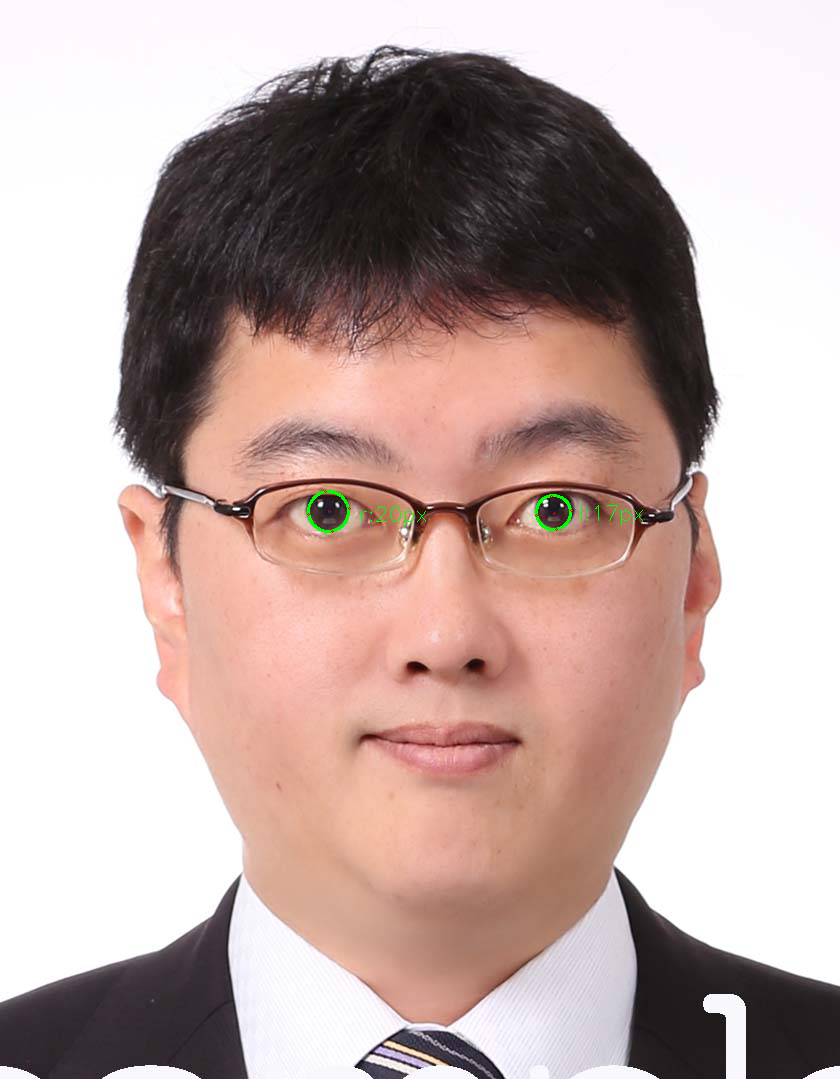

In [6]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
import copy

import cv2 as cv
import numpy as np

from IPython.display import Image



# For static images:
img_path = '/content/drive/MyDrive/Deep_learning/face.jpg'
#img_path = '/content/drive/MyDrive/Deep_learning/666mai_dataset/gravcont元画像/grav/1043.JPG'
image = cv2.imread(img_path)

#ここからがメイン

# 引数 #####################################################################

max_num_faces = 1
min_detection_confidence = 0.7
min_tracking_confidence = 0.7


# モデルロード #############################################################
face_mesh = FaceMesh(
    max_num_faces,
    min_detection_confidence,
    min_tracking_confidence,
)
iris_detector = IrisLandmark()



# 検出実施 #############################################################
# Face Mesh検出
face_results = face_mesh(image)
for face_result in face_results:
    # 目周辺のバウンディングボックス計算
    left_eye, right_eye = face_mesh.calc_around_eye_bbox(face_result)

    # 虹彩検出
    left_iris, right_iris = detect_iris(image, iris_detector, left_eye,
                                        right_eye)

    # 虹彩の外接円を計算
    left_center, left_radius = calc_min_enc_losingCircle(left_iris)
    right_center, right_radius = calc_min_enc_losingCircle(right_iris)

    # デバッグ描画
    debug_image = copy.deepcopy(image)
    debug_image = draw_debug_image(
        debug_image,
        left_iris,
        right_iris,
        left_center,
        left_radius,
        right_center,
        right_radius,
    )
"""
cv.putText(debug_image, "FPS:" + str(display_fps), (10, 30),
            cv.FONT_HERSHEY_SIMPLEX, 1.0, (0, 255, 0), 2, cv.LINE_AA)
"""

cv2_imshow(debug_image)

cv.destroyAllWindows()


